## Imports 

In [7]:
# all imports
import os
import math
import glob
import time
import pandas as pd
import numpy as np

# remove warnings
import warnings
warnings.filterwarnings("ignore")

# to display all rows columns 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# for better EDA
import pandas_profiling as pp

# data viz
import matplotlib.pyplot as plt
%matplotlib notebook 
%matplotlib inline
# other data viz libraries
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [8]:
# # to install any missing libraries
# !pip install pandas-profiling --user

In [12]:
# read csv
match = pd.read_csv('IPL_ball_by_ball_updated.csv')

In [13]:
match.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,6.800,Royal Challengers Bangalore,Kolkata Knight Riders,MV Boucher,CL White,AB Agarkar,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,2.700,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,AB Dinda,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.100,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.200,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335982,2008,2008-04-18,M Chinnaswamy Stadium,2,3.300,Royal Challengers Bangalore,Kolkata Knight Riders,JH Kallis,W Jaffer,I Sharma,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# remove super overs
match = match[match.innings <= 2]
match.reset_index(inplace = True, drop = True)

In [15]:
# player profile dataset
player_profile = pd.read_excel('cricsheet_cricbuzz_mapping_updated.xlsx')

In [16]:
# shortname for batting style
player_profile['batting_style'] = player_profile['bat_style']
player_profile['batting_style'] = player_profile['bat_style']

player_profile['batting_style'] = player_profile['batting_style'].replace(' Right Handed Bat ', 'RHB')
player_profile['batting_style'] = player_profile['batting_style'].replace(' Left Handed Bat ', 'LHB')

In [17]:
player_profile['bowl_style'] = player_profile['bowl_style'].replace([' -- ', 'None'], 'Others')

In [18]:
def get_bowl_type(bowl_type_fullname):
    if bowl_type_fullname in [' Left-arm fast-medium ', ' Left-arm fast ', ' Left-arm medium ', ' Right-arm medium ', ' Right-arm fast-medium ', ' Right-arm fast ' ]:
        return 'Pace'
    elif bowl_type_fullname in [' Left-arm orthodox ', ' Left-arm chinaman ', ' Right-arm legbreak ',  ' Right-arm offbreak ']:
        return 'Spin'
    else:
        return None

In [19]:
player_profile['bowling_style'] = player_profile['bowl_style'].apply(lambda x: get_bowl_type(x))

In [20]:
bowler_player_profile = player_profile[['cricsheet_name', 'bowl_style', 'bowling_style']].rename(columns = {'cricsheet_name':'bowler'})
match = match.merge(bowler_player_profile, on = 'bowler', how = 'left')

In [21]:
batsman_player_profile = player_profile[['cricsheet_name', 'bat_style', 'batting_style']].rename(columns = {'cricsheet_name':'striker'})
match = match.merge(batsman_player_profile, on = 'striker', how = 'left')

In [22]:
# clean venues 
match['venue']=match['venue'].str.replace('Arun Jaitley Stadium, Delhi','Arun Jaitley Stadium')
match['venue']=match['venue'].str.replace('Brabourne Stadium, Mumbai','Brabourne Stadium')
match['venue']=match['venue'].str.replace('Dr DY Patil Sports Academy, Mumbai','Dr DY Patil Sports Academy')
match['venue']=match['venue'].str.replace('Eden Gardens, Kolkata','Eden Gardens')
match['venue']=match['venue'].str.replace('M Chinnaswamy Stadium','M.Chinnaswamy Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chepauk','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chepauk Chennai','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('MA Chidambaram Stadium, Chennai','MA Chidambaram Stadium')
match['venue']=match['venue'].str.replace('Maharashtra Cricket Association Stadium, Pune','Maharashtra Cricket Association Stadium')
match['venue']=match['venue'].str.replace('Punjab Cricket Association IS Bindra Stadium, Mohali','Punjab Cricket Association IS Bindra Stadium')
match['venue']=match['venue'].str.replace('Punjab Cricket Association Stadium, Mohali','Punjab Cricket Association IS Bindra Stadium')
match['venue']=match['venue'].str.replace('Rajiv Gandhi International Stadium, Uppal','Rajiv Gandhi International Stadium')
match['venue']=match['venue'].str.replace('Wankhede Stadium, Mumbai','Wankhede Stadium')


In [23]:
def wides_calc(wides):
    # check if its a nan
    if wides != wides:
        return 1
    else:
        return 0

def noballs_calc(noballs, runs_off_bat):
  # check if its a nan
    if noballs != noballs:
        return 1
    elif runs_off_bat >= 0:
        return 1
    else:
        return 0

def noballs_calc_bowler(noballs):
    # check if its a nan
    if noballs != noballs:
        return 1
    else:
        return 0

def byes_calc(byes):
    # check for nan
    if byes != byes:
        return 1
    elif byes >= 1:
        return 1
    else:
        return 0

def legbyes_calc(leg_byes):
    if leg_byes != leg_byes:
        return 1
    elif leg_byes >= 1:
        return 1
    else:
        return 0

# balls_faced = not extras + no_balls (with runs scored) + byes + legbyes

In [24]:
# Balls_faced
match['wides_cnt_balls'] = match['wides'].apply(lambda x: wides_calc(x))
match['noballs_cnt_balls'] = match.apply(lambda x: noballs_calc(x['noballs'], x['runs_off_bat']), axis = 1 )
match['noballs_cnt_balls_bowler'] = match.apply(lambda x: noballs_calc_bowler(x['noballs']), axis = 1 )
match['byes_cnt_balls'] = match['byes'].apply(lambda x: byes_calc(x))
match['legbyes_cnt_balls'] = match['legbyes'].apply(lambda x: legbyes_calc(x))

# assign legal_ball flag
match['legal_ball'] = match.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)
match['legal_ball_bowler'] = match.apply(lambda x: 0 if min(x['wides_cnt_balls'], x['noballs_cnt_balls_bowler'], x['byes_cnt_balls'], x['legbyes_cnt_balls']) == 0 else 1, axis = 1)

In [25]:
match['over_no'] = match['ball'].apply(lambda x: int(str(x).split('.')[0]))
match['ball_no'] = match['ball'].apply(lambda x: int(str(x).split('.')[1]))

In [26]:
def phase(over_no):
    if over_no < 6:
        return "PP"
    elif over_no < 16:
        return "MO"
    else:
        return "DO"

In [27]:
match['phase'] = match['over_no'].apply(lambda x: phase(x))

In [28]:
match.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,bowl_style,bowling_style,bat_style,batting_style,wides_cnt_balls,noballs_cnt_balls,noballs_cnt_balls_bowler,byes_cnt_balls,legbyes_cnt_balls,legal_ball,legal_ball_bowler,over_no,ball_no,phase
0,335982,2008,2008-04-18,M.Chinnaswamy Stadium,2,6.800,Royal Challengers Bangalore,Kolkata Knight Riders,MV Boucher,CL White,AB Agarkar,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast-medium,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,6,8,MO
1,335982,2008,2008-04-18,M.Chinnaswamy Stadium,2,2.700,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,AB Dinda,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast-medium,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,2,7,PP
2,335982,2008,2008-04-18,M.Chinnaswamy Stadium,2,3.100,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast-medium,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,3,1,PP
3,335982,2008,2008-04-18,M.Chinnaswamy Stadium,2,3.200,Royal Challengers Bangalore,Kolkata Knight Riders,W Jaffer,JH Kallis,I Sharma,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast-medium,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,3,2,PP
4,335982,2008,2008-04-18,M.Chinnaswamy Stadium,2,3.300,Royal Challengers Bangalore,Kolkata Knight Riders,JH Kallis,W Jaffer,I Sharma,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast-medium,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,3,3,PP


## Fact Checks

In [29]:
# cross check with bumrah vs kohli

In [30]:
df1 = match[(match.striker == 'V Kohli') & (match.bowler == 'JJ Bumrah')]

In [31]:
df1.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,bowl_style,bowling_style,bat_style,batting_style,wides_cnt_balls,noballs_cnt_balls,noballs_cnt_balls_bowler,byes_cnt_balls,legbyes_cnt_balls,legal_ball,legal_ball_bowler,over_no,ball_no,phase
76745,597999,2013,2013-04-04,M.Chinnaswamy Stadium,1,4.500,Royal Challengers Bangalore,Mumbai Indians,V Kohli,CH Gayle,JJ Bumrah,0,0,NaN,NaN,NaN,NaN,NaN,lbw,V Kohli,NaN,NaN,Right-arm fast,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,4,5,PP
76770,597999,2013,2013-04-04,M.Chinnaswamy Stadium,1,4.100,Royal Challengers Bangalore,Mumbai Indians,V Kohli,CH Gayle,JJ Bumrah,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,4,1,PP
76771,597999,2013,2013-04-04,M.Chinnaswamy Stadium,1,4.200,Royal Challengers Bangalore,Mumbai Indians,V Kohli,CH Gayle,JJ Bumrah,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,4,2,PP
76772,597999,2013,2013-04-04,M.Chinnaswamy Stadium,1,4.300,Royal Challengers Bangalore,Mumbai Indians,V Kohli,CH Gayle,JJ Bumrah,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,4,3,PP
76773,597999,2013,2013-04-04,M.Chinnaswamy Stadium,1,4.400,Royal Challengers Bangalore,Mumbai Indians,V Kohli,CH Gayle,JJ Bumrah,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Right-arm fast,Pace,Right Handed Bat,RHB,1,1,1,1,1,1,1,4,4,PP


http://www.cricmetric.com/matchup.py?batsman=V+Kohli&bowler=JJ+Bumrah&groupby=year

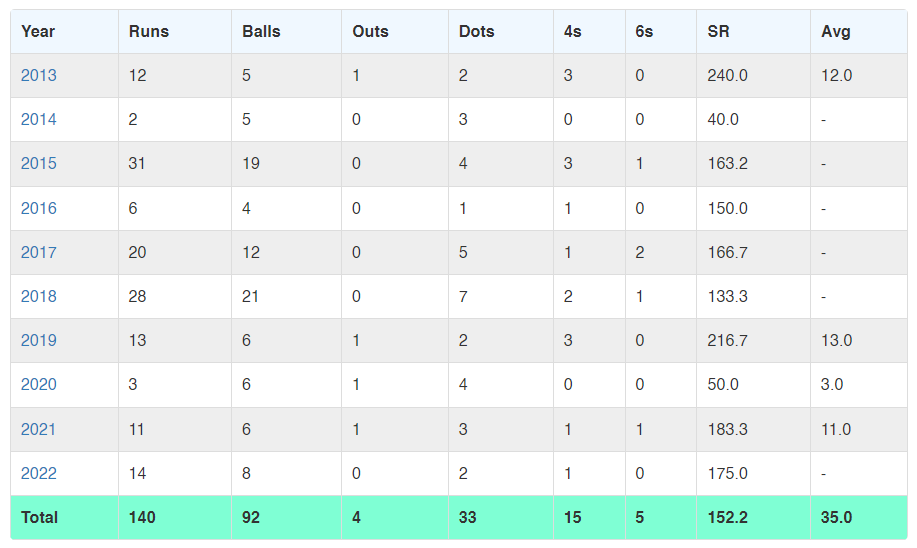

In [34]:
df1.groupby(['season'])['legal_ball'].sum()

season
2013    5 
2014    5 
2015    19
2016    4 
2017    12
2018    21
2019    6 
2020    6 
2021    6 
2022    8 
Name: legal_ball, dtype: int64

In [35]:
df1.groupby(['season'])['runs_off_bat'].sum()

season
2013    12
2014    2 
2015    31
2016    6 
2017    20
2018    28
2019    13
2020    3 
2021    11
2022    14
Name: runs_off_bat, dtype: int64

## Export

In [36]:
match.to_csv('cleaned_ipl_dataset_2008_to_2022.csv', index = False)